In [1]:
  # --------------------数据读取---------------------------------
from __future__ import print_function, division

import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary

from NeuralNetworks.VGG import VGG

batch_size = 16
learning_rate = 0.0002
lastEpoch = 149
Epoch = 150
TRAIN = True
dataPath = '../DBtest/img/'
checkPointPath = '../DBtest/checkPoint/VGG_checkPoint/'

train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
test_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
val_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

train_dir = dataPath + 'train'
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

test_dir = dataPath + 'test'
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

val_dir = dataPath + 'val'
val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True)

In [2]:
  # --------------------模型定义---------------------------------

def VGG_11():
    return VGG([1, 1, 2, 2, 2], num_classes=10)

def VGG_13():
    return VGG([1, 1, 2, 2, 2], num_classes=10)

def VGG_16():
    return VGG([2, 2, 3, 3, 3], num_classes=10)

def VGG_19():
    return VGG([2, 2, 4, 4, 4], num_classes=10)

model = VGG_16()
if torch.cuda.is_available():
    model.cuda()
    print('Using GPU')
summary(model, (3, 224, 224))


# params = [{'params': md.parameters()} for md in model.children()
#           if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
start_epoch = 0

completeCheckPointPath = checkPointPath + 'VGG_best_' + str(lastEpoch) + '.pth'
if os.path.exists(completeCheckPointPath):
    path_checkpoint = completeCheckPointPath  # 断点路径
    checkpoint = torch.load(path_checkpoint)  # 加载断点
    model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch'] + 1  # 设置开始的epoch

Using GPU


D:\code\python\DeepLearning\NeuralNetworks\VGG.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc3(out))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7        [-1, 128, 112, 112]          73,728
       BatchNorm2d-8        [-1, 128, 112, 112]             256
              ReLU-9        [-1, 128, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]         147,456
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
           Conv2d-13          [-1, 256, 56, 56]         294,912
      BatchNorm2d-14          [-1, 256,

In [ ]:
  # --------------------训练过程---------------------------------

if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
else:
    Loss_list = []

if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
else:
    Accuracy_list = []

for epoch in range(start_epoch, Epoch):
    print('epoch {}'.format(epoch))
    # training-----------------------------
    model.train()
    train_loss = 0.
    train_acc = 0.
    print('Training...')
    trainBar = tqdm(total=len(train_dataloader))
    for step, (batch_x, batch_y) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        else:
            batch_x, batch_y = Variable(batch_x), Variable(batch_y)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.data
        pred = torch.max(out, 1)[1]
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainBar.update(1)
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / len(train_datasets), train_acc / len(train_datasets)))
    trainBar.close()

    # 断点保存
    checkpoint = {
        "net": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, checkPointPath + 'VGG_best_%s.pth' %(str(epoch)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    print('Testing...')
    testBar = tqdm(total=len(val_dataloader))
    for batch_x, batch_y in val_dataloader:
        with torch.no_grad():
            if torch.cuda.is_available():
                batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
            else:
                batch_x, batch_y = Variable(batch_x), Variable(batch_y)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        eval_loss += loss.data
        pred = torch.max(out, 1)[1]
        num_correct = (pred == batch_y).sum()
        eval_acc += num_correct.data
        testBar.update(1)
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(val_datasets), eval_acc / len(val_datasets)))
    testBar.close()

    # 断点保存
    if epoch >= len(Loss_list):
        Loss_list = np.hstack((Loss_list, eval_loss.data.cpu() / len(val_datasets)))
        Accuracy_list = np.hstack((Accuracy_list, 100 * eval_acc.data.cpu() / len(val_datasets)))
    else:
        Loss_list[epoch] = eval_loss.data.cpu() / len(val_datasets)
        Accuracy_list[epoch] = 100 * eval_acc.data.cpu() / len(val_datasets)

    np.save(checkPointPath + 'loss', Loss_list)
    np.save(checkPointPath + 'accuracy', Accuracy_list)
# 画图
x1 = range(0, 10)
x2 = range(0, 10)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")

In [8]:
  # --------------------测试过程---------------------------------
model.eval()
eval_loss = 0.
eval_acc = 0.
print('Testing...')
testBar = tqdm(total=len(test_dataloader))
for batch_x, batch_y in test_dataloader:
    with torch.no_grad():
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        else:
            batch_x, batch_y = Variable(batch_x), Variable(batch_y)
    out = model(batch_x)
    loss = loss_func(out, batch_y)
    eval_loss += loss.data
    pred = torch.max(out, 1)[1]
    num_correct = (pred == batch_y).sum()
    eval_acc += num_correct.data
    testBar.update(1)
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(test_datasets), eval_acc / len(test_datasets)))
testBar.close()


Testing...


  0%|          | 0/647 [00:00<?, ?it/s]

Test Loss: 0.101424, Acc: 0.839053


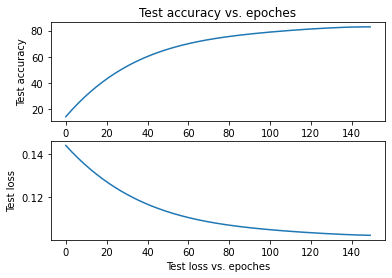

In [2]:
  # --------------------数据展示---------------------------------
import numpy as np
import matplotlib.pyplot as plt
import os

checkPointPath = '../DBtest/checkPoint/VGG_checkPoint/'

if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
else:
    Loss_list = []

if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
else:
    Accuracy_list = []

x1 = range(0, len(Loss_list))
x2 = range(0, len(Loss_list))

f1 = np.polyfit(x1, Loss_list, 4)
p1 = np.poly1d(f1)
fitLoss_list = p1(x1)  #拟合y值

f2 = np.polyfit(x1, Accuracy_list, 4)
p2 = np.poly1d(f2)
fitAccuracy_list = p2(x1)

y1 = fitAccuracy_list
y2 = fitLoss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, '-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()